In [6]:
import copy

# import cProfile
import itertools

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.stats as st

import neuro_op as nop

In [17]:
nop.plot_setup()
cmap = "inferno"

In [18]:
# Reference input, to be adapted, just here for reference
input = dict(
    G=nop.build_random_network(N_nodes=100, N_neighbours=5),
    llf_nodes=st.norm,
    params_node=dict(
        loc=0,
        scale=10,
    ),
    sd_llf=1,
    llf_world=st.norm,
    params_world=dict(
        loc=0,
        scale=1,
    ),
    h=1,
    r=1,
    t0=0,
    t_max=100,
    t_sample=1,
    sampling=True,
    init_rngs=False,
    seed=False,
)

In [42]:
np.round(np.linspace(1, 14, 10), 0)

array([ 1.,  2.,  4.,  5.,  7.,  8., 10., 11., 13., 14.])

In [38]:
# i.g. sourced form
# 1. Dunbar 1993 (BEHAVIORAL AND BRAIN SCIENCES (1993) 16:4)
# 2. Dunbar 2008, https://doi.org/10.1037/1089-2699.12.1.7
# 3. Yellow (June 25, 2018)
# (4. Lazily extrapolate N, nn from (x_{n+1})_n = n*ln(n) with n_0 = )

nn = [10, (5, 15)]  # from 2
N = [
    1,  # for simple understanding
    2,  # for simple understanding
    150,  # from 1
    500,  # from 3
]

# MA1 )
sd_llf_arr = np.arange(0.25, 2.1, 0.25)
nn_arr = np.arange(2.5, 21, 2.5)

# MA2 )
sd_arr = np.arange(0.25, 2.1, 0.25)

# MA3 )
mu_arr = np.arange(0, 10.1, 2)
sd_arr = np.arange(1, 10.1, 1.5)
r_arr = np.arange(1, 10.1, 1.5)

0.0 1.0 0.25
0.0 1.0 0.5
0.0 1.0 0.75
0.0 1.0 1.0
0.0 1.0 1.25
0.0 1.0 1.5
0.0 1.0 1.75
0.0 1.0 2.0
0.0 2.5 0.25
0.0 2.5 0.5
0.0 2.5 0.75
0.0 2.5 1.0
0.0 2.5 1.25
0.0 2.5 1.5
0.0 2.5 1.75
0.0 2.5 2.0
0.0 4.0 0.25
0.0 4.0 0.5
0.0 4.0 0.75
0.0 4.0 1.0
0.0 4.0 1.25
0.0 4.0 1.5
0.0 4.0 1.75
0.0 4.0 2.0
0.0 5.5 0.25
0.0 5.5 0.5
0.0 5.5 0.75
0.0 5.5 1.0
0.0 5.5 1.25
0.0 5.5 1.5
0.0 5.5 1.75
0.0 5.5 2.0
0.0 7.0 0.25
0.0 7.0 0.5
0.0 7.0 0.75
0.0 7.0 1.0
0.0 7.0 1.25
0.0 7.0 1.5
0.0 7.0 1.75
0.0 7.0 2.0
0.0 8.5 0.25
0.0 8.5 0.5
0.0 8.5 0.75
0.0 8.5 1.0
0.0 8.5 1.25
0.0 8.5 1.5
0.0 8.5 1.75
0.0 8.5 2.0
0.0 10.0 0.25
0.0 10.0 0.5
0.0 10.0 0.75
0.0 10.0 1.0
0.0 10.0 1.25
0.0 10.0 1.5
0.0 10.0 1.75
0.0 10.0 2.0
2.0 1.0 0.25
2.0 1.0 0.5
2.0 1.0 0.75
2.0 1.0 1.0
2.0 1.0 1.25
2.0 1.0 1.5
2.0 1.0 1.75
2.0 1.0 2.0
2.0 2.5 0.25
2.0 2.5 0.5
2.0 2.5 0.75
2.0 2.5 1.0
2.0 2.5 1.25
2.0 2.5 1.5
2.0 2.5 1.75
2.0 2.5 2.0
2.0 4.0 0.25
2.0 4.0 0.5
2.0 4.0 0.75
2.0 4.0 1.0
2.0 4.0 1.25
2.0 4.0 1.5
2.0 4.0 1.75
2.0 

In [20]:
# out1 = nop.run_ConjMu(**nop.input_ref_ConjMu)
out1 = nop.run_ConjMu(**input)
out1["seed"]

299565282850689126664732061696902967868

In [21]:
nop.export_hdf5(out1, "test.h5")

In [22]:
out1 = nop.import_hdf5("test.h5", True, True, True)

## Data analysis

Random data analysis test notebook of steps later used in thorough analysis.


#### Data analysis 1

Firstly, extract output values for further analysis:

In [23]:
for i in out1.keys():
    print(i)

world
G
N_events
t_end
t_start
t_exec
seed
nodesConjMu
mu_nodes
sd_nodes
kl_divs



Each node's posteriors are plotted. One should see nodes' posteriors of model parameters (in this case, $\mu$), to converge around the true value. If not, nodes may need more information to converge ($\rightarrow$ increase $t_{max}, h$).


(array([ 2.,  4.,  5.,  4., 13., 16., 10., 15., 11.,  7.,  1.,  3.,  2.,
         3.,  0.,  2.,  1.,  0.,  0.,  1.]),
 array([0.03826366, 0.04142694, 0.04459023, 0.04775352, 0.0509168 ,
        0.05408009, 0.05724337, 0.06040666, 0.06356995, 0.06673323,
        0.06989652, 0.07305981, 0.07622309, 0.07938638, 0.08254967,
        0.08571295, 0.08887624, 0.09203952, 0.09520281, 0.0983661 ,
        0.10152938]),
 <BarContainer object of 20 artists>)

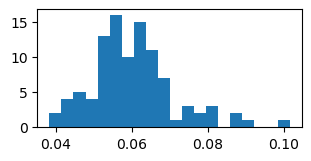

In [24]:
sigmas = []
for i in out1["nodesConjMu"]:
    sigmas += [i.params_node["scale"]]
fig, ax = plt.subplots()
ax.hist(sigmas, bins=20)

[[-1.14870951e+01  4.80000000e+01  4.20795603e-02]
 [-1.08559243e+01  4.80000000e+01  1.69235658e-01]
 [-2.18705692e+01  3.70000000e+01  2.32579198e-01]
 ...
 [-2.65452353e+00  5.80000000e+01  9.96105538e+01]
 [ 1.58568616e+00 -1.00000000e+00  9.97203413e+01]
 [-2.34370627e+00  3.70000000e+01  9.98676312e+01]]


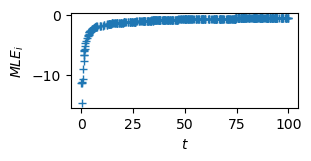

In [29]:
# Implement external sampling routine (or rather test if feasible)
k = 0
nody = out1["nodesConjMu"][k]
# mu_nody = np.array(out1["mu_nodes"])[:, k][1:]
#
fig, ax = plt.subplots()
# ax.plot(
#    np.arange(input["t0"], input["t_max"], input["t_sample"]),
#    mu_nody,
# )

mu, sig = input["params_node"].values()
sd_llf = input["sd_llf"]
x_in = np.array(nody.diary_in)
post_mu = x_in[:, 0]
post_sig = np.zeros_like(post_mu)

i = -1
post_mu[i], post_sig[i] = mu, sig
for i, _ in enumerate(x_in):
    post_mu[i] = (post_sig[i - 1] ** 2 * x_in[i, 0] + sd_llf**2 * post_mu[i - 1]) / (
        post_sig[i - 1] ** 2 + sd_llf**2
    )
    post_sig[i] = (1 / post_sig[i - 1] ** 2 + 1 / sd_llf**2) ** (-0.5)

# ax.set_ylim(-1, 1)
ax.plot(x_in[:, 2], post_mu, "+", alpha=1)
ax.set_xlabel("$t$")
ax.set_ylabel("$MLE_i$")

print(nody.diary_in)
# fig.savefig("graphics-output/TMP-mu_N1.png", dpi=1500)

(101, 100)
101


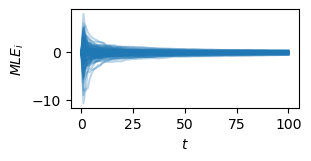

In [26]:
mu_arr = np.array(out1["mu_nodes"])
print(mu_arr.shape)
x = np.arange(input["t0"], input["t_max"] + input["t_sample"], input["t_sample"])
print(len(x))
fig, ax = plt.subplots()
for i, mu in enumerate(mu_arr.T):
    ax.plot(x, mu, alpha=0.3, label=f"$\mu_{i}$", color="tab:blue")
    ax.set_xlabel("$t$")
    ax.set_ylabel("$MLE_i$")
# ax.set_ylim(-100, 100)
# ax.set_yscale("log")
# ax.loglog()
# ax.legend()
# fig.savefig("./graphics-output/TMP-mu_nodes.png", dpi=1500)

#### Data analysis 2

(1, 100)

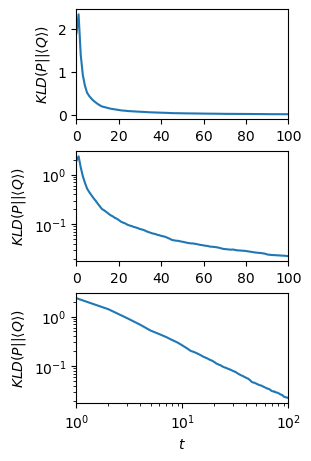

In [27]:
# for i in N_iter:
#    plt.plot(input["t_sample"] * np.arange(0, kld.shape[0]), kld[:, i, ])
kld = np.array(out1["kl_divs"])
fig, ax = plt.subplots(3, 1, constrained_layout=True, figsize=(3, 4.5))
x = input["t_sample"] * np.arange(0, kld.shape[0])
for i, _ in enumerate(ax):
    ax[i].plot(
        x,  # input["t_sample"] * np.arange(0, kld.shape[0]),
        kld.mean(axis=1),
        label="$KLD_i$",
    )
    ax[i].set_ylabel(r"$KLD(P||\langle Q \rangle )$")
    ax[i].set_xlim(0, x[-1])
ax[2].set_xlabel("$t$")
ax[1].set_yscale("log")
ax[2].loglog()
ax[2].set_xlim(input["t_sample"], input["t_max"])
# fig.savefig("./graphics-output/TMP-KLD.png", dpi=1500)

(101, 100)


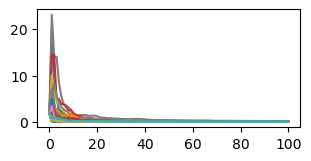

In [28]:
# for i in N_iter:
#    plt.plot(input["t_sample"] * np.arange(0, kld.shape[0]), kld[:, i, ])
kld = np.array(out1["kl_divs"])
print(kld.shape)
fig, ax = plt.subplots(constrained_layout=True, figsize=(3, 1.5))
for i, _ in enumerate(kld.T):
    ax.plot(
        input["t_sample"] * np.arange(0, kld.shape[0]),
        kld[:, i],
        label="avg",
    )
# plt.loglog()
# plt.ylim(0, 2)